# Inpainting de paisajes con autoencoders (Avance)

## Importaciones

In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.mixed_precision import set_global_policy

from google.colab import files
from google.colab import drive
from huggingface_hub import hf_hub_download

set_global_policy('mixed_float16')

drive.mount('/content/drive')
!git clone --branch train "https://github.com/LaucoTec/Inpainting_TC3007C.git"

Mounted at /content/drive
Cloning into 'Inpainting_TC3007C'...
remote: Enumerating objects: 23511, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 23511 (delta 0), reused 0 (delta 0), pack-reused 23510 (from 3)
Receiving objects: 100% (23511/23511), 483.91 MiB | 39.41 MiB/s, done.
Resolving deltas: 100% (3/3), done.


## Primer intento: Simple reconstrucción

### Cargar datasets

In [ ]:
trainFolder = '/content/Inpainting_TC3007C/paisajes/Landscape Classification/Landscape Classification/Training Data/Mountain'
valFolder = '/content/Inpainting_TC3007C/paisajes/Landscape Classification/Landscape Classification/Validation Data/Mountain'
imgSize = (290, 174) # Tamaño original de las imágenes
batchSize = 32 # Tamaño de bloques

trainDS = tf.keras.utils.image_dataset_from_directory(
    trainFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

valDS = tf.keras.utils.image_dataset_from_directory(
    valFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

print(f"Dataset de entrenamiento cargado desde {trainFolder}")
print(f"Dataset de validación cargado desde {valFolder}")

Found 2000 files.
Found 300 files.
Dataset de entrenamiento cargado desde /content/Inpainting_TC3007C/paisajes/Landscape Classification/Landscape Classification/Training Data/Mountain
Dataset de validación cargado desde /content/Inpainting_TC3007C/paisajes/Landscape Classification/Landscape Classification/Validation Data/Mountain


Cargar únicamente conjuntos para entrenar y validar. no hay intención de seguir trabajando sobre esta pequeña iteración para probar más a detalle con un set dedicado de prueba.

La propia imagen es el objetivo, por lo que no se extraen etiquetas. Se separa por batches de 32 imágenes con mezclado aleatorio para que no se memorice el orden de los datos originales.

### Preprocesamiento

In [ ]:
# Preprocesamiento a imágenes
def trainPre(image):
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.random_flip_left_right(image)
    return image, image

def valPre(image):
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    return image, image


# Preprocesamiento a datasets
trainDS = (
    trainDS
    .shuffle(1000)
    .map(trainPre, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

valDS = (
    valDS
    .map(valPre, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


print(f"Nuevos detalles de entrenamiento: {trainDS.element_spec}")
print(f"Nuevos detalles de validación: {valDS.element_spec}")

Nuevos detalles de entrenamiento: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))
Nuevos detalles de validación: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))


En el preprocesado se normalizan todas las imágenes para valores de entre 0 y 1 para facilitar la convergencia, se activa un barajeo de mil imágenes para que en las épocas no se memorice un orden fijo ahora de los datos en el set cargado. Cache y prefetch permiten cargar todo en memoria aprovechando que aún son pocos datos para apurar el entrenamiento. Las imágenes se reducen a un 128x128 pues no se ocupa tanta información para la única clase que debe aprender.

Finalmente, el único aumento de datos aplicado es una inversión horizontal de las imágenes.  

### Construir el modelo

In [ ]:
# Profundidad de 3
encoder = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(16, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(1024, activation='linear')
])

decoder = keras.Sequential([
    layers.Input(shape=(1024,)),

    layers.Dense(16 * 16 * 64, activation='relu'),
    layers.Reshape((16, 16, 64)),

    layers.UpSampling2D(size=2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.UpSampling2D(size=2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.UpSampling2D(size=2),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.Conv2D(3, 3, padding='same', activation='sigmoid')
])


La arquitectura es sencilla con una profundidad de 3 antes del cuello de botella:
- Convoluciones con 2 de padding para reducir el tamaño y filtros de 16 hasta 64 para algo ligero.
  - ReLu se usa como función de activación aprovechando el recorte de 0 a 1 y evitar el desvanecimiento de gradiente.
- La regularización se hace por bloques al tener un tamaño de batch no tan pequeño, tras cada convolución.
- El cuello de botella final es una capa densa de 1024 neuronas de activación lineal.
- El decodificador, con la operación opuesta, realiza el upsampling antes de las convoluciones.
- La salida final es con una convolución de 3 filtros y kernel de 3.
  - Su activación es sigmoide ya que los valores originales se encontraban ya entre 0 y 1.

In [ ]:
# Definir la entrada
input_img = keras.Input(shape=(128, 128, 3))

# Generar el encoder
encoded = encoder(input_img)

# Generar el decoder
decoded = decoder(encoded)

# Unir las partes
autoencoder = keras.Model(inputs=input_img, outputs=decoded)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1024)           │    16,802,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │    16,854,499 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,656,771 (128.39 MB)

 Trainable params: 33,656,323 (128.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Generar modelo final
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError()
)

# Definir callbacks durante entrenamiento
# Early Stop
early = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# Checkpoints
ckptPath = "/content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5"
ckpt = keras.callbacks.ModelCheckpoint(
    filepath=ckptPath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

Adam se usa como optimizador frecuentemente gracias a que puede ajustar la tasa de aprendizaje y corregir sesgos mientras mantiene un gran desempeño. La tasa original de 0.001 es de igual forma un valor frecuente.

Se definen dos callbacks:
- EarlyStopping para prevenir sobreajuste cuando la pérdida del set de validación ya no mejore o empeore.
- Checkpoint para guardar la mejor versión del modelo siempre.

In [ ]:
history = autoencoder.fit(
    trainDS,
    epochs=50,
    validation_data=valDS,
    callbacks=[early, ckpt]
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0518
Epoch 1: val_loss improved from inf to 0.05545, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 317s 4s/step - loss: 0.0515 - val_loss: 0.0554
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0219
Epoch 2: val_loss improved from 0.05545 to 0.04351, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - loss: 0.0218 - val_loss: 0.0435
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0175
Epoch 3: val_loss improved from 0.04351 to 0.03795, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - loss: 0.0175 - val_loss: 0.0379
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0156
Epoch 4: val_loss improved from 0.03795 to 0.02991, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - loss: 0.0156 - val_loss: 0.0299
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0147
Epoch 5: val_loss improved from 0.02991 to 0.02040, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 282s 4s/step - loss: 0.0147 - val_loss: 0.0204
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0134
Epoch 6: val_loss improved from 0.02040 to 0.01698, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/BasicAE/ae_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - loss: 0.0134 - val_loss: 0.0170
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0128
Epoch 7: val_loss did not improve from 0.01698
63/63 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - loss: 0.0128 - val_loss: 0.0176
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0121
Epoch 8: val_loss did not improve from 0.01698
63/63 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - loss: 0.0121 - val_loss: 0.0182
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0115
Epoch 9: val_loss did not improve from 0.01698
63/63 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - loss: 0.0115 - val_loss: 0.0193
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0112
Epoch 10: val_loss did not improve from 0.01698
63/63 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - loss: 0.0112 - val_loss: 0.0247
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0110
Epoch 11: val_loss did not improve from 0.01698
63/63 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - loss: 0.0110 - val_loss: 0.02

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


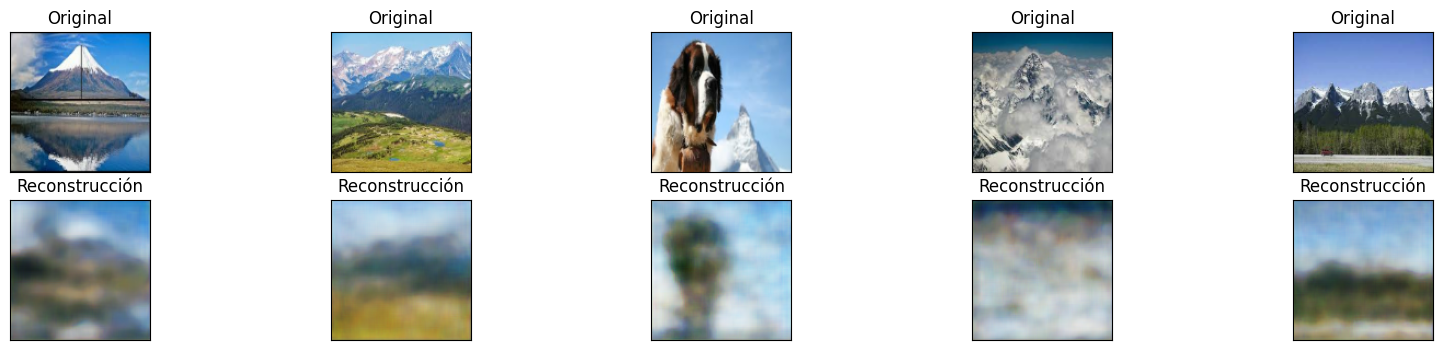

In [ ]:
n = 5 # 5 ejemplos
plt.figure(figsize=(20, 4))

# Obtener un batch del set de validación
for x, _ in valDS.take(1):
    imgs = x.numpy()
    decoded_imgs = autoencoder.predict(imgs)

for i in range(n):
    # Mostrar orignal
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Mostrar reconstruido
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstrucción")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Naturalmente, los resultados son borrosos por ser una versión muy simple y limitada. Sin embargo, la silueta general de las imágenes se puede mantener tras la compresión. Algo a notar que artefactos externos al paisaje se intentan reinterpretar con la información aprendida, como se puede ver en la imagen con un perro que fue convertido en una montaña.

## Segundo intento: Denoiser con 2 clases

### Cargar datos

In [9]:
trainFolder = '/content/Inpainting_TC3007C/paisajes/Training Data'
valFolder = '/content/Inpainting_TC3007C/paisajes/Validation Data'
testFolder = '/content/Inpainting_TC3007C/paisajes/Testing Data'
imgSize = (160, 272) # Tamaño original: 174x290
batchSize = 32

trainDS = tf.keras.utils.image_dataset_from_directory(
    trainFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

valDS = tf.keras.utils.image_dataset_from_directory(
    valFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

testDS = tf.keras.utils.image_dataset_from_directory(
    testFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

print(f"Dataset de entrenamiento cargado desde {trainFolder}")
print(f"Dataset de validación cargado desde {valFolder}")
print(f"Dataset de prueba cargado desde {testFolder}")

Found 6000 files.
Found 900 files.
Found 300 files.
Dataset de entrenamiento cargado desde /content/Inpainting_TC3007C/paisajes/Training Data
Dataset de validación cargado desde /content/Inpainting_TC3007C/paisajes/Validation Data
Dataset de prueba cargado desde /content/Inpainting_TC3007C/paisajes/Testing Data


### Preprocesar

Nuevos detalles de entrenamiento: (TensorSpec(shape=(None, 160, 272, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 272, 3), dtype=tf.float32, name=None))
Nuevos detalles de validación: (TensorSpec(shape=(None, 160, 272, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 272, 3), dtype=tf.float32, name=None))
Nuevos detalles de prueba: (TensorSpec(shape=(None, 160, 272, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 272, 3), dtype=tf.float32, name=None))


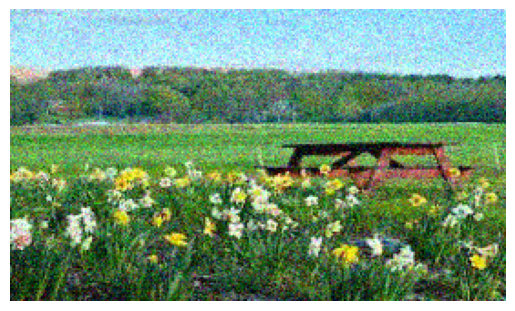

In [10]:
# Preprocesamiento a imágenes
def trainPre(image):
    clean = tf.cast(image, tf.float32) / 255.0

    clean = tf.image.random_flip_left_right(clean)
    clean = tf.image.random_brightness(clean, max_delta=0.1)
    noisy = clean + tf.random.normal(tf.shape(clean), stddev=0.1)
    noisy = tf.clip_by_value(noisy, 0.0, 1.0)

    return noisy, clean

def valPre(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image, image


# Preprocesamiento a datasets
trainDS = (
    trainDS
    .shuffle(1000)
    .map(trainPre, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

valDS = (
    valDS
    .map(valPre, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

testDS = (
    testDS
    .map(valPre, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


print(f"Nuevos detalles de entrenamiento: {trainDS.element_spec}")
print(f"Nuevos detalles de validación: {valDS.element_spec}")
print(f"Nuevos detalles de prueba: {testDS.element_spec}")

for noisyImg, cleanImg in trainDS.take(1):
  noisyImg = np.clip(noisyImg[0], 0.0, 1.0).astype(np.float32)
  plt.imshow(noisyImg)
  plt.axis('off')
  plt.show()
  break

### Construir el modelo

In [11]:
encoder = keras.Sequential([
    layers.Input(shape=(160, 272, 3)),
    layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
    layers.GroupNormalization(groups=1),

    layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
    layers.GroupNormalization(groups=1),

    layers.Conv2D(128, 3, activation='relu', strides=2, padding='same'),
    layers.GroupNormalization(groups=1),

    layers.Conv2D(256, 3, activation='relu', strides=2, padding='same'),
    layers.GroupNormalization(groups=1)
])

decoder = keras.Sequential([
    layers.Input(shape=(10, 17, 256)),

    layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu'),
    layers.GroupNormalization(groups=1),

    layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu'),
    layers.GroupNormalization(groups=1),

    layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
    layers.GroupNormalization(groups=1),

    layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
    layers.GroupNormalization(groups=1),

    layers.Conv2D(3, 3, padding='same', activation='sigmoid')
])

In [13]:
# Definir la entrada
input = keras.Input(shape=(160, 272, 3))

# Generar el encoder
encoded = encoder(input)

# Generar el decoder
decoded = decoder(encoded)

# Construir el modelo, como funciones
autoencoder = keras.Model(inputs=input, outputs=decoded)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 272, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 10, 17, 256)    │       389,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 272, 3)    │       979,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,368,579 (5.22 MB)

 Trainable params: 1,368,579 (5.22 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Generar modelo final
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='MAE'
)

# Definir callbacks durante entrenamiento
# Early Stop
early = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# Checkpoints
ckptPath = "/content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn3_best.keras"
ckpt = keras.callbacks.ModelCheckpoint(
    filepath=ckptPath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [16]:
history = autoencoder.fit(
    trainDS,
    epochs=60,
    validation_data=valDS,
    callbacks=[early, ckpt]
)

Epoch 1/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.1369
Epoch 1: val_loss improved from inf to 0.07889, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn3_best.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 86s 261ms/step - loss: 0.1367 - val_loss: 0.0789
Epoch 2/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0737
Epoch 2: val_loss improved from 0.07889 to 0.07679, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn3_best.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - loss: 0.0737 - val_loss: 0.0768
Epoch 3/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0641
Epoch 3: val_loss improved from 0.07679 to 0.06316, saving model to /content/drive/MyDrive/Colab Notebooks/Inpainting/Models/DenoiserAE/dn3_best.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 121ms/step - loss: 0.0641 - val_loss: 0.0632
Epoch 4/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0570
Epoch 4: val_loss did not improve from 0.

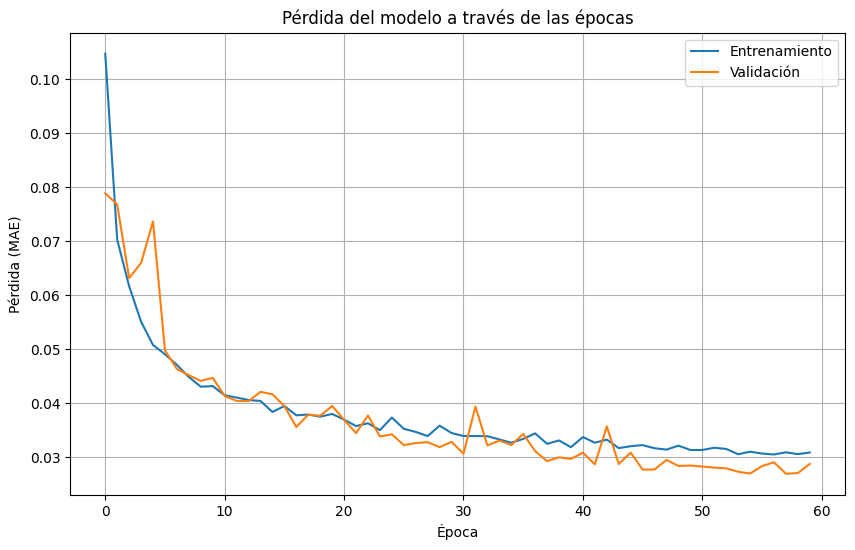

In [17]:
# Gráfica de pérdida
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo a través de las épocas')
plt.ylabel('Pérdida (MAE)')
plt.xlabel('Época')
plt.legend()
plt.grid(True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


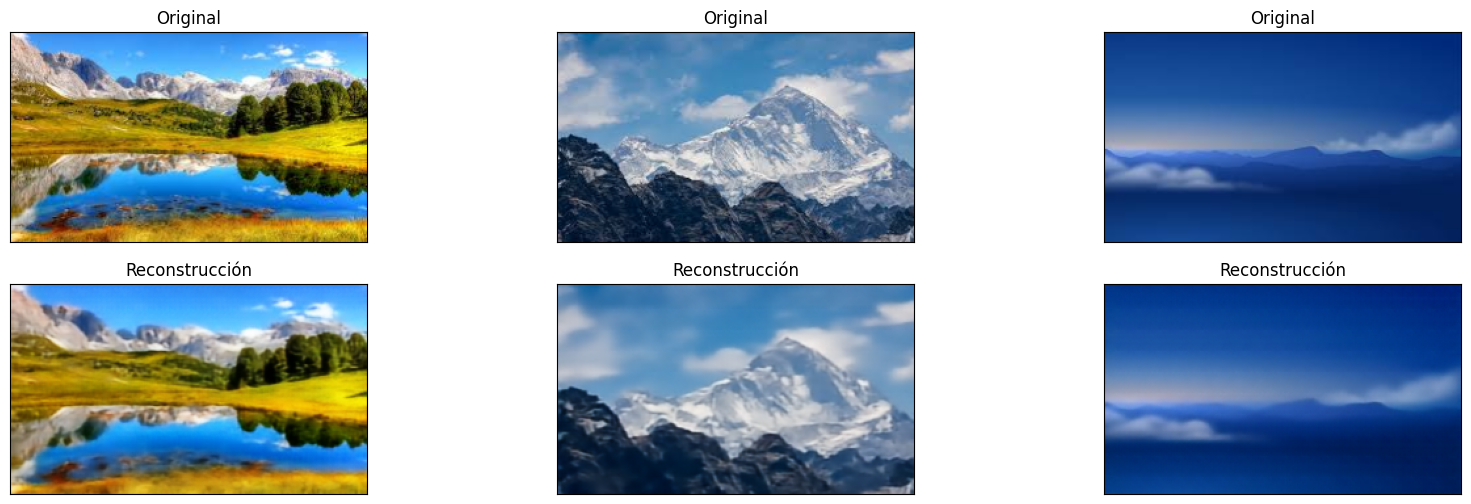

In [19]:
n = 3 # Mostrar 3 ejemplos
plt.figure(figsize=(20, 6))

# Obtener batch del set de prueba
for noisyImg, cleanImg in testDS.take(1):
    ogImg = cleanImg.numpy() # Imagen limpia como 'original'
    decodedImg = autoencoder.predict(noisyImg) # Predecir con la imagen ruidosa

for i in range(n):
    # Convertir al tipo y rango de valor correcto
    displayOg = np.clip(ogImg[i], 0.0, 1.0).astype(np.float32)
    displayDc = np.clip(decodedImg[i], 0.0, 1.0).astype(np.float32)

    # Imagen original y sin ruido
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(displayOg)
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(displayDc)
    plt.title("Reconstrucción")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Tercer intento: Camino al Inpainting

### Cargar sets de datos

In [ ]:
trainFolder = '/content/Inpainting_TC3007C/paisajes/Training Data'
valFolder = '/content/Inpainting_TC3007C/paisajes/Validation Data'
testFolder = '/content/Inpainting_TC3007C/paisajes/Testing Data'
imgSize = (160, 272) # Tamaño original: 174x290
batchSize = 32

trainDS = tf.keras.utils.image_dataset_from_directory(
    trainFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

valDS = tf.keras.utils.image_dataset_from_directory(
    valFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

testDS = tf.keras.utils.image_dataset_from_directory(
    testFolder,
    labels=None,
    label_mode=None,
    image_size=imgSize,
    batch_size=batchSize,
    shuffle=True
)

print(f"Dataset de entrenamiento cargado desde {trainFolder}")
print(f"Dataset de validación cargado desde {valFolder}")
print(f"Dataset de prueba cargado desde {testFolder}")

### Preprocesamiento

In [ ]:
# Preprocesamiento a imágenes
def trainPre(image):
    clean = tf.cast(image, tf.float32) / 255.0

    clean = tf.image.random_flip_left_right(clean)
    clean = tf.image.random_brightness(clean, max_delta=0.1)
    noisy = clean + tf.random.normal(tf.shape(clean), stddev=0.1)
    noisy = tf.clip_by_value(noisy, 0.0, 1.0)

    return noisy, clean

def valPre(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image, image


# Preprocesamiento a datasets
trainDS = (
    trainDS
    .shuffle(1000)
    .map(trainPre, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

valDS = (
    valDS
    .map(valPre, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

testDS = (
    testDS
    .map(valPre, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


print(f"Nuevos detalles de entrenamiento: {trainDS.element_spec}")
print(f"Nuevos detalles de validación: {valDS.element_spec}")
print(f"Nuevos detalles de prueba: {testDS.element_spec}")

# Imagen de muestra (tras aumento)
for noisyImg, cleanImg in trainDS.take(1):
  noisyImg = np.clip(noisyImg[0], 0.0, 1.0).astype(np.float32)
  plt.imshow(noisyImg)
  plt.axis('off')
  plt.show()
  break

### Definición del modelo

In [ ]:
# Función de pérdida
def charbonnierLoss(y_true, y_pred, epsilon=3e-3):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(epsilon)))

In [ ]:
# Arquitectura
encoder = keras.Sequential([
    layers.Input(shape=(160, 272, 3)),
    layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
    layers.GroupNormalization(groups=1),

    layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
    layers.GroupNormalization(groups=1),

    layers.Conv2D(128, 3, activation='relu', strides=2, padding='same'),
    layers.GroupNormalization(groups=1),

    layers.Conv2D(256, 3, activation='relu', strides=2, padding='same'),
    layers.GroupNormalization(groups=1)
])

decoder = keras.Sequential([
    layers.Input(shape=(10, 17, 256)),

    layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu'),
    layers.GroupNormalization(groups=1),

    layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu'),
    layers.GroupNormalization(groups=1),

    layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
    layers.GroupNormalization(groups=1),

    layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
    layers.GroupNormalization(groups=1),

    layers.Conv2D(3, 3, padding='same', activation='sigmoid')
])

In [ ]:
# Definir la entrada
input = keras.Input(shape=(160, 272, 3))

# Generar el encoder
encoded = encoder(input)

# Generar el decoder
decoded = decoder(encoded)

# Construir el modelo
autoencoder = keras.Model(inputs=input, outputs=decoded)
autoencoder.summary()

In [ ]:
# Compilar modelo
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss= charbonnierLoss
)

# Callbacks de entrenamiento
# Early Stop
early = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# Checkpoints
ckptPath = "/content/drive/MyDrive/Colab Notebooks/Inpainting/Models/InpaintingAE/ip_best.keras"
ckpt = keras.callbacks.ModelCheckpoint(
    filepath=ckptPath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

### Entrenamiento

In [ ]:
# Entrenar el modelo
history = autoencoder.fit(
    trainDS,
    epochs=60,
    validation_data=valDS,
    callbacks=[early, ckpt]
)

In [ ]:
# Gráfica de pérdida
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo a través de las épocas')
plt.ylabel('Pérdida (MAE)')
plt.xlabel('Época')
plt.legend()
plt.grid(True)

In [ ]:
# Mostrar desempeño con un ejemplo
n = 3 # Mostrar 3 ejemplos
plt.figure(figsize=(20, 6))

# Obtener batch del set de prueba
for noisyImg, cleanImg in testDS.take(1):
    ogImg = ogImg.numpy() # Imagen limpia
    decodedImg = autoencoder.predict(noisyImg) # Entrada del modelo

for i in range(n):
    # Convertir al tipo y rango de valor correcto
    displayOg = np.clip(ogImg[i], 0.0, 1.0).astype(np.float32)
    displayDc = np.clip(decodedImg[i], 0.0, 1.0).astype(np.float32)

    # Imagen original y sin ruido
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(displayOg)
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(displayDc)
    plt.title("Reconstrucción")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Probar

In [ ]:
# Cargar el modelo
repo = "LaucoTec/TC3007C_Inpainting"
modelPath = hf_hub_download(
    repo_id=repo,
    filename="models/DenoiserAE/dn3_best.keras"
    )


denoiser = tf.keras.models.load_model(modelPath)

print(f"Cargado modelo de Denoiser desde: {modelPath}")
denoiser.summary()

Cargado modelo de Denoiser desde: /root/.cache/huggingface/hub/models--LaucoTec--TC3007C_Inpainting/snapshots/188c0fadae268decb664d71e5686be5cba0f30ae/models/DenoiserAE/dn3_best.keras


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 272, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 10, 17, 256)    │       389,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 272, 3)    │       979,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,105,743 (15.66 MB)

 Trainable params: 1,368,579 (5.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,737,164 (10.44 MB)

In [ ]:
# Subir la imagen a probar
uploaded = files.upload()

data = uploaded[list(uploaded.keys())[0]]
img = tf.image.decode_image(data, channels=3)
img = tf.image.resize(img, (160, 272))
img = tf.cast(img, tf.float32) / 255.0
inputImg = np.expand_dims(img, axis=0)

noise = inputImg + tf.random.normal(tf.shape(input), stddev=0.1)
noise = tf.clip_by_value(noise, 0.0, 1.0)

print("Imagen cargada y preprocesada.")

Saving Glacier (319).jpeg to Glacier (319).jpeg
Imagen cargada y preprocesada.


**De momento sólo funciona con bosques, glaciares o montañas.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


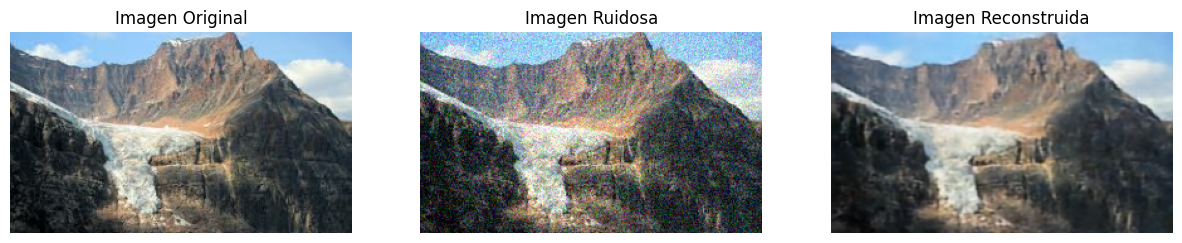

In [ ]:
# Asegurar sí se subió una imagen
if 'input' in locals():
    # Usar el modelo
    denoised = denoiser.predict(noise)
    denoised = np.clip(denoised, 0.0, 1.0).astype(np.float32)

    # Mostrar resultados
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1) # Imagen original
    plt.imshow(input[0])
    plt.title("Imagen Original")
    plt.axis('off')

    plt.subplot(1, 3, 2) # Imagen ruidosa
    plt.imshow(noise[0])
    plt.title("Imagen Ruidosa")
    plt.axis('off')

    plt.subplot(1, 3, 3) # Imagen reconstruida
    plt.imshow(denoised[0])
    plt.title("Imagen Reconstruida")
    plt.axis('off')

    plt.show()
else:
    print("No se subió una imagen.")